# About:
- this notebook:
    1. performs **deep feature selection using featuretools**
    2. adds top n engineered features based on feature importance to original dataset and evaluate performance
    3. adds every engineered feature individually to original dataset and evaluate performance
    4. adds every pair of engineered feature to original dataset and evaluate performance
- insights:
    1. we **cannot use feature importance to select top n engineered features**, because they may be correlated with original features and cause a loss of performance
    2. Instead, **Exhuastive Method of trying every individual/paired engineered feature can lead to some gains**
    3. Investigatations from future notebooks suggest that I should have used Cross Validation when performing exhaustive search on the engineered features. Simple fit predict is not reliable enough to find good engineered features
    4. **future projects should use Exhaustive Cross Validation on each engineered feature** from featuretools

In [1]:
target_colnames = ['h1n1_vaccine', 'seasonal_vaccine']
X = pd.read_csv(r"C:\Users\tanch\Documents\Coding Competitions\DataDriven\Flu Shot Learning\local\data\cleaned_train_set.csv") 
y = X[target_colnames[0]]
X.drop(target_colnames,axis=1,inplace=True)

<IPython.core.display.Javascript object>

## Create EntitySet 
- a collection of tables

In [2]:
import featuretools as ft
es = ft.EntitySet(id = 'Vaccine')

## Featuretools variable types
- it's **important to specify the right variable type** for featuretools because different types have different operations that are appropriate for them
- important ones:
    - Categorical(unordered), Ordinal(ordered), Boolean, Numeric

In [3]:
from datasets import ClassLabel, Sequence
import pandas as pd
from IPython.display import display, HTML
def show_elements(dataset, randomize = True, num_samples = 10):
    
    if isinstance(dataset,pd.DataFrame):                  # if DataFrame 
        if randomize:                                          # if random> shuffle
            dataset = dataset.sample(frac=1)
        display(HTML(dataset.iloc[:num_samples].to_html()))             # take first n rows
    
    else:                                                    # if not DataFrame
        if randomize:                                           # if random> shuffle
            dataset = dataset.shuffle()   
        dataset = pd.DataFrame(dataset.select(range(num_samples)))   # convert first n rows to dataframe
        display(HTML(dataset.to_html()))
    

In [4]:
# list of variable types in featuretools software
from featuretools.variable_types import list_variable_types
featuretools_dtypes = list_variable_types()
show_elements(featuretools_dtypes,randomize = False, num_samples = len(featuretools_dtypes))

,name,type_string,description
0,Unknown,unknown,None
1,Discrete,discrete,Superclass representing variables that take on discrete values
2,Categorical,categorical,"Represents variables that can take an unordered discrete values\n\n Args:\n categories (list) : List of categories. If left blank, inferred from data.\n"
3,Id,id,Represents variables that identify another entity
4,ZIPCode,zip_code,Represents a postal address in the United States.\n Consists of a series of digits which are casts as\n string. Five digit and 9 digit zipcodes are supported.\n
5,CountryCode,country_code,Represents an ISO-3166 standard country code.\n ISO 3166-1 (countries) are supported. These codes\n should be in the Alpha-2 format.\n e.g. United States of America = US\n
6,SubRegionCode,sub_region_code,"Represents an ISO-3166 standard sub-region code.\n ISO 3166-2 codes (sub-regions are supported. These codes\n should be in the Alpha-2 format.\n e.g. United States of America, Arizona = US-AZ\n"
7,Ordinal,ordinal,Represents variables that take on an ordered discrete value
8,Boolean,boolean,"Represents variables that take on one of two values\n\n Args:\n true_values (list) : List of valued true values. Defaults to [1, True, ""true"", ""True"", ""yes"", ""t"", ""T""]\n false_values (list): List of valued false values. Defaults to [0, False, ""false"", ""False"", ""no"", ""f"", ""F""]\n"
9,Numeric,numeric,"Represents variables that contain numeric values\n\n Args:\n range (list, optional) : List of start and end. Can use inf and -inf to represent infinity. Unconstrained if not specified.\n start_inclusive (bool, optional) : Whether or not range includes the start value.\n end_inclusive (bool, optional) : Whether or not range includes the end value\n\n Attributes:\n max (float)\n min (float)\n std (float)\n mean (float)\n"


In [5]:
boolean_colnames = []
ordinal_colnames = []
categorical_colnames = []
numeric_colnames = []
for col in X.columns:
    nunique = X[col].nunique()
    if nunique==2:                              
        boolean_colnames.append(col)
    elif "opinion" in col or "h1n1" in col:     # these cols specify rating, so they are ordinal
        ordinal_colnames.append(col)
    elif "household" in col: 
        numeric_colnames.append(col)
    elif "employment" in col:
        categorical_colnames.append(col)
    # print(f"{col}: {nunique}")

In [6]:
categorical_colnames.extend(["health_insurance","race","employment_status","census_msa","hhs_geo_region"])
ordinal_colnames.extend(["age_group","education","income_poverty"])

### Variable dtypes
- grouped features into their dtypes:
    - boolean - yes/no features
    - ordinal - ratings or categories that have an increasing order e.g poverty
    - nominal(categorical) - no obvious order e.g industry type
    - numerical 

In [7]:
print(f"boolean_colnames: {boolean_colnames}\n" )
print(f"ordinal_colnames: {ordinal_colnames}\n" )
print(f"categorical_colnames: {categorical_colnames}\n" )
print(f"numeric_colnames: {numeric_colnames}\n" )

boolean_colnames: ['behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal', 'chronic_med_condition', 'child_under_6_months', 'health_worker', 'sex', 'marital_status', 'rent_or_own']

ordinal_colnames: ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group', 'education', 'income_poverty']

categorical_colnames: ['employment_status', 'employment_industry', 'employment_occupation', 'health_insurance', 'race', 'employment_status', 'census_msa', 'hhs_geo_region']

numeric_colnames: ['household_adults', 'household_children']



## Add Entity/table
- To specify:
    1. entity_id 
    2. index - column of unique values
    3. variable_types - ensures that appropriate engineering operations are performed

In [8]:
import featuretools.variable_types as vtypes
variable_types = {}
for col in boolean_colnames:
    variable_types.update({col:vtypes.Boolean})
for col in ordinal_colnames:
    variable_types.update({col:vtypes.Ordinal})
for col in categorical_colnames:
    variable_types.update({col:vtypes.Categorical})
for col in numeric_colnames:
    variable_types.update({col:vtypes.Numeric})

In [9]:
es = es.entity_from_dataframe(entity_id = 'Vaccine',    # table name
                              dataframe = X, 
                              index = 'respondent_id',                # every table needs an index column 
                              variable_types=variable_types)      

# Deep Feature Selection (DFS) - ft.dfs()
- featuretools automatically stacks feature transformations and aggregations
- for DFS to occur you must :
    1. have **more than one entity set for DFS**
    2. set **max_depth more than 1**

In [10]:
for col in categorical_colnames:
    es = es.normalize_entity(base_entity_id='Vaccine', new_entity_id=col, index=col)

C:\Users\tanch\anaconda3\lib\site-packages\featuretools\entityset\entityset.py:265: UserWarning: Not adding duplicate relationship: <Relationship: Vaccine.employment_status -> employment_status.employment_status>
  warnings.warn(


In [46]:
feature_matrix, feature_names = ft.dfs(entityset=es, 
                                        target_entity = 'Vaccine', 
                                        max_depth = 2, 
                                        verbose = 3, 
                                        n_jobs = 1,
                                        ignore_variables={'Vaccine':['respondent_id']})

Built 462 features
Elapsed: 00:03 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


In [33]:
param = {
"learning_rate":0.05 ,
"max_depth" : 4,
"colsample_bytree" :0.8,
"subsample" :0.8,
#'objective': 'binary',
"metric" :'auc'
# "n_estimators" : 1000
}

### benchmark - original data

In [121]:
score_board = {}

In [123]:
train_data = Dataset(X.iloc[:,1:],y)
score_board["original"] = lgb.cv(param, train_data, num_boost_round = 1000, nfold=3, early_stopping_rounds = 50)['auc-mean']

### evaluate - original data + top n engineered features

In [126]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feature_matrix,y,test_size = 0.30,random_state = 0)
train_data = Dataset(X_train,y_train)
validation_data = Dataset(X_test,y_test)
bst = lgb.train(param, train_data, 1000, valid_sets=[validation_data],early_stopping_rounds = 50,verbose_eval  = False)

In [129]:
for n in [0,1,2,3,4,5,10,20,30]:
    top_n_colnames = pd.Series(dict(zip(bst.feature_name(),bst.feature_importance()))).sort_values(ascending=False)[:35].keys()
    best_cols = [col for col in top_n_colnames if col not in X.columns][:n]
    train_data = Dataset(feature_matrix[best_cols+list(X.columns[1:])],y)
    score_board[f"original+{n} top engineered features"] = lgb.cv(param, train_data, num_boost_round = 1000, nfold=3, early_stopping_rounds = 50)['auc-mean']

## Result
- the performance on original data is the blue or orange line
- Insights:
    - adding the top 1-5 engineered features based on feature importance worsens performance
        - i hypoethesize that those features were **correlated with original features, so there was no point adding them**
    - however, **there are features among the top 30 features which does improve performance** (blue line)
        - therefore, let's add features one by one to sea which are the engineered features that improve performance

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[(0.864, 0.87)]

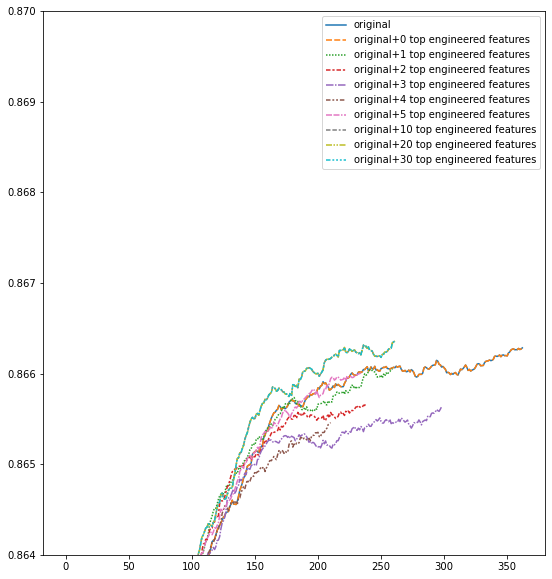

In [153]:
f, axes = plt.subplots(1, 1,figsize = (9,10))
sns.lineplot(data = score_board).set(ylim = (0.864,0.87))

## Extract features that improve model performance

In [180]:
from sklearn.metrics import roc_auc_score 
engineered_features = [col for col in feature_matrix if col not in X.columns]
original_features = list(X.columns[1:])

In [168]:
param = {
"learning_rate":0.05 ,
"max_depth" : 4,
"colsample_bytree" :0.8,
"subsample" :0.8,
#'objective': 'binary',
"metric" :'auc',
"n_estimators" : 500
}

In [172]:
from lightgbm import LGBMClassifier
score_board = {}
X_train, X_test, y_train, y_test = train_test_split(feature_matrix[original_features],y,test_size = 0.30,random_state = 0)
# train_data = Dataset(X_train,y_train)
# validation_data = Dataset(X_test,y_test)
model = LGBMClassifier()
model.set_params(**param)
model.fit(X_train,y_train,eval_set = (X_test,y_test),early_stopping_rounds = 50,verbose = False)
y_pred = model.predict_proba(X_test)[:,1]
score_board['original'] = roc_auc_score(y_test,y_pred)

In [182]:
from tqdm import tqdm
for col in tqdm(list(engineered_features)):
    X_train, X_test, y_train, y_test = train_test_split(feature_matrix[original_features+[col]],y,test_size = 0.30,random_state = 0)
    model = LGBMClassifier()
    model.set_params(**param)
    model.fit(X_train,y_train,eval_set = (X_test,y_test),early_stopping_rounds = 50,verbose = False)
    y_pred = model.predict_proba(X_test)[:,1]
    score_board[f"original+{col}"] = roc_auc_score(y_test,y_pred)

100%|████████████████████████████████████████████████████████████████████████████████| 427/427 [04:46<00:00,  1.49it/s]


## Result 
- there are over 100 features that lead to some improvement when added individually
- **hhs_geo_region.SKEW(Vaccine.household_children) led to 0.0015 gain in auc**

In [248]:
gain_features =  {k:score for k,score in score_board.items() if score>score_board['original'] or k=="original"}
pd.Series(gain_features).sort_values(ascending = False)

original+hhs_geo_region.SKEW(Vaccine.household_children)                  0.867901
original+employment_occupation.PERCENT_TRUE(Vaccine.marital_status)       0.867478
original+employment_occupation.MODE(Vaccine.census_msa)                   0.867253
original+hhs_geo_region.STD(Vaccine.household_children)                   0.867243
original+hhs_geo_region.PERCENT_TRUE(Vaccine.child_under_6_months)        0.867221
                                                                            ...   
original+hhs_geo_region.NUM_UNIQUE(Vaccine.employment_industry)           0.866507
original+employment_industry.NUM_UNIQUE(Vaccine.employment_occupation)    0.866491
original+hhs_geo_region.MODE(Vaccine.census_msa)                          0.866489
original+hhs_geo_region.PERCENT_TRUE(Vaccine.behavioral_avoidance)        0.866488
original                                                                  0.866480
Length: 118, dtype: float64

## Further selection:
- among the top 20 engineered feature that led to performance gains, i will try adding every pair

In [236]:
from itertools import combinations
pairs = list(combinations(list(map(lambda x: x.split("+")[1],list(pd.Series(gain_features).sort_values(ascending = False)[:20].keys()))),2))

In [242]:
score_board_pairs = {}
from tqdm import tqdm
for combination in tqdm(list(pairs)):
    X_train, X_test, y_train, y_test = train_test_split(feature_matrix[original_features+list(combination)],y,test_size = 0.30,random_state = 0)
    model = LGBMClassifier()
    model.set_params(**param)
    model.fit(X_train,y_train,eval_set = (X_test,y_test),early_stopping_rounds = 50,verbose = False)
    y_pred = model.predict_proba(X_test)[:,1]
    score_board_pairs[f"original+{combination}"] = roc_auc_score(y_test,y_pred)

100%|████████████████████████████████████████████████████████████████████████████████| 190/190 [02:12<00:00,  1.43it/s]


## Results
- **('hhs_geo_region.SKEW(Vaccine.household_children)', 'employment_industry.PERCENT_TRUE(Vaccine.rent_or_own)') pair led to 0.0016** gain in auc

In [243]:
gain_pairs =  {k:score for k,score in score_board_pairs.items() if score>score_board['original'] or k=="original"}
pd.Series(gain_pairs).sort_values(ascending = False)

original+('hhs_geo_region.SKEW(Vaccine.household_children)', 'employment_industry.PERCENT_TRUE(Vaccine.rent_or_own)')            0.868028
original+('hhs_geo_region.SKEW(Vaccine.household_children)', 'employment_industry.MODE(Vaccine.age_group)')                      0.867949
original+('hhs_geo_region.STD(Vaccine.household_children)', 'employment_industry.PERCENT_TRUE(Vaccine.rent_or_own)')             0.867579
original+('hhs_geo_region.STD(Vaccine.household_children)', 'employment_industry.PERCENT_TRUE(Vaccine.doctor_recc_seasonal)')    0.867565
original+('employment_occupation.PERCENT_TRUE(Vaccine.marital_status)', 'employment_industry.MODE(Vaccine.age_group)')           0.867551
                                                                                                                                   ...   
original+('hhs_geo_region.NUM_UNIQUE(Vaccine.employment_occupation)', 'census_msa.PERCENT_TRUE(Vaccine.doctor_recc_h1n1)')       0.866494
original+('hhs_geo_region.NUM_UNIQ

### export engineered features

In [264]:
feature_matrix[['hhs_geo_region.SKEW(Vaccine.household_children)', 'employment_industry.PERCENT_TRUE(Vaccine.rent_or_own)']].to_csv(r"C:\Users\tanch\Documents\Coding Competitions\DataDriven\Flu Shot Learning\local\data\train engineered_feature 0.csv")
feature_matrix[['hhs_geo_region.SKEW(Vaccine.household_children)', 'employment_industry.PERCENT_TRUE(Vaccine.rent_or_own)']].head()

,hhs_geo_region.SKEW(Vaccine.household_children),employment_industry.PERCENT_TRUE(Vaccine.rent_or_own)
respondent_id,,
0,1.445465,0.228432
1,1.477455,0.280617
2,1.568201,0.476099
3,1.422831,0.228432
4,1.568201,0.155211


In [251]:
test_set = pd.read_csv(r"C:\Users\tanch\Documents\Coding Competitions\DataDriven\Flu Shot Learning\local\data\cleaned_test_set.csv") 

In [257]:
# creating and entity set 'es'
es_tst = ft.EntitySet(id = 'Vaccine')
# adding a dataframe 
es_tst.entity_from_dataframe(entity_id = 'Vaccine', dataframe = test_set, index = 'respondent_id',variable_types=variable_types)
# add entity
es_tst = es_tst.normalize_entity(base_entity_id='Vaccine', new_entity_id='hhs_geo_region', index='hhs_geo_region')
es_tst = es_tst.normalize_entity(base_entity_id='Vaccine', new_entity_id='employment_industry', index='employment_industry')

In [261]:
feature_matrix_test, feature_names_test = ft.dfs(entityset=es_tst, 
                                                target_entity = 'Vaccine', 
                                                max_depth = 2, 
                                                verbose = 3, 
                                                n_jobs = 1,
                                                ignore_variables={'Vaccine':[col for col in test_set.columns if col not in ["hhs_geo_region","employment_industry","household_children","rent_or_own"]]})

Built 22 features
Elapsed: 00:00 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


In [265]:
feature_matrix_test[['hhs_geo_region.SKEW(Vaccine.household_children)', 'employment_industry.PERCENT_TRUE(Vaccine.rent_or_own)']].to_csv(r"C:\Users\tanch\Documents\Coding Competitions\DataDriven\Flu Shot Learning\local\data\test engineered_feature 0.csv")
feature_matrix_test[['hhs_geo_region.SKEW(Vaccine.household_children)', 'employment_industry.PERCENT_TRUE(Vaccine.rent_or_own)']].head()

,hhs_geo_region.SKEW(Vaccine.household_children),employment_industry.PERCENT_TRUE(Vaccine.rent_or_own)
respondent_id,,
26707,1.439036,0.175182
26708,1.633696,0.175182
26709,1.479701,0.167808
26710,1.479701,0.224557
26711,1.569159,0.201691
